In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf

In [2]:
# Mover el intérprete una carpeta hacia atrás
os.chdir("..")

# Verificar el directorio actual
print("Current working directory:", os.getcwd())

Current working directory: d:\root\repos\orian-backend-django


In [3]:
from orian_online_simulation.simulation import OnlineSimulation
from orian_online_simulation.market import Asset, Currency, StockMarketHandler
from orian_online_simulation.trading.algorithm import TrendAlgorithm
from orian_online_simulation.transaction import (
    Wallet, 
    TransactionQuantityManagerByWalletPercentage, 
    TransactionQuantityManagerByFixedAmount,
    TransactionTriggerByRepeatedPredictions
)
from orian_online_simulation.strategy import AutomatedStrategy

# Estructura de una simulación offline

Una simulación offline tiene la siguiente estructura:

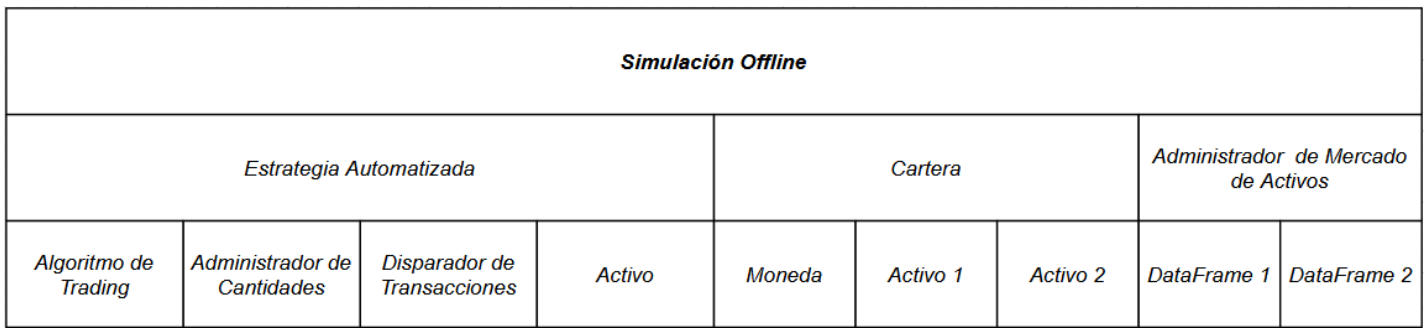

Podemos detectar distintas partes:

- **Estrategia automatizada:** Encapsula el algoritmo de trading y se encarga de decidir cuándo comprar y vender.
- **Cartera:** Almacena los activos y la moneda que se tienen en cada momento.
- **Administrador de Mercado de Activos:** Gestiona los data-frames de precios de los activos.

Una simulación puede tener varias estrategias automatizadas, pero compartiendo la misma cartera y administrador de mercado de activos. A continuación, se muestra un ejemplo de cómo se puede configurar una simulación offline con `orian_online_simulation`.

# Obtener parámetros necesarios para la configuración


**Obtener activos, moneda y billetera:**

In [17]:
SPY_asset = Asset("SPY")
AMBZ_asset = Asset("AMBZ")
USD_currency = Currency("USD")
wallet = Wallet(
    amounts={
        SPY_asset:1000,
        AMBZ_asset:1000,
        USD_currency:1000,   
    },
    base_currency=USD_currency
)

print(wallet)

Wallet(amounts={Asset(name='SPY'): 1000, Asset(name='AMBZ'): 1000, Currency(name='USD'): 1000}, base_currency=Currency(name='USD'))


**Obtener Stock Market:**

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

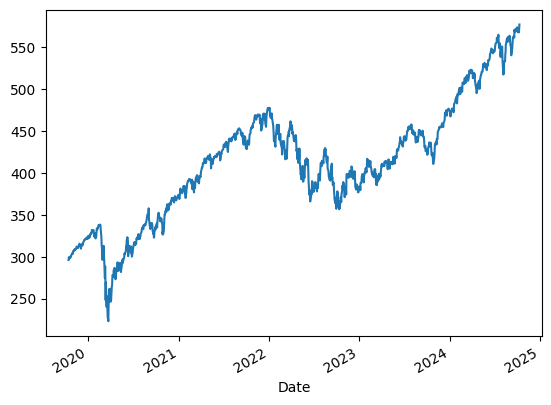

In [18]:
# SPY stock market
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*5)

spy_df = yf.download(["SPY"], start_date, end_date)
spy_df["Close"].plot()

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

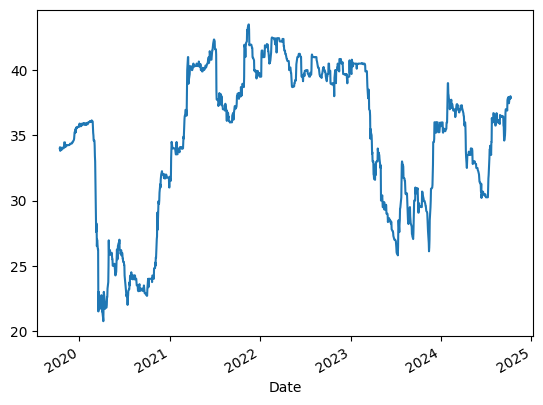

In [19]:
ambz_df = yf.download(["ambz"], start_date, end_date)
ambz_df["Close"].plot()

In [20]:
stock_market_handler = StockMarketHandler(
    stock_market_dict={
        SPY_asset:spy_df,
        AMBZ_asset:ambz_df
    }
)

**Obtener administrador de cantidades y disparador:**

In [21]:
# SPY strategy components
buy_spy_quantity_manager = TransactionQuantityManagerByWalletPercentage(
    wallet=wallet,
    percentage=0.05,
)

sell_spy_quantity_manager = TransactionQuantityManagerByFixedAmount(
    wallet=wallet,
    currency_amount_to_buy=1,
    asset_amount_to_sell=1,
)

spy_trigger = TransactionTriggerByRepeatedPredictions(
    repetitions=2,
)

# AMBZ strategy components
buy_ambz_quantity_manager = TransactionQuantityManagerByWalletPercentage(
    wallet=wallet,
    percentage=0.01,
)

# AMBZ strategy components
sell_ambz_quantity_manager = TransactionQuantityManagerByFixedAmount(
    wallet=wallet,
    currency_amount_to_buy=2,
    asset_amount_to_sell=2,
)

ambz_trigger = TransactionTriggerByRepeatedPredictions(
    repetitions=1,
)

**Obtener algoritmo de trading y estrategia automatizada:**

In [22]:
spy_trading_algorithm = TrendAlgorithm(n=4)
spy_automated_strategy = AutomatedStrategy(
    trading_algorithm=spy_trading_algorithm,
    trading_asset=SPY_asset,
    priority=1,
    transaction_trigger=spy_trigger,
    buy_transaction_quantity_manager=buy_spy_quantity_manager,
    sell_transaction_quantity_manager=sell_spy_quantity_manager,
)

In [23]:
ambz_trading_algorithm = TrendAlgorithm(n=3)
ambz_automated_strategy = AutomatedStrategy(
    trading_algorithm=ambz_trading_algorithm,
    trading_asset=AMBZ_asset,
    priority=1,
    transaction_trigger=ambz_trigger,
    buy_transaction_quantity_manager=buy_ambz_quantity_manager,
    sell_transaction_quantity_manager=sell_ambz_quantity_manager,)

# Simulación de trading

Una vez obtenida la configuración, se procede a realizar la simulación de trading.

In [24]:
simulation = OnlineSimulation(
    stock_market_handler=stock_market_handler,
    strategies=[
        spy_automated_strategy,
        ambz_automated_strategy
    ],
    wallet=wallet,
    max_transaction_date_difference=1
)

In [25]:
simulation.run_simulation()

In [26]:
len(simulation.history)

510

In [27]:
history_df = simulation.simulation_history_dataframe

In [28]:
history_df

,strategy,amount,transaction_type,total_net_value,Asset(name='SPY'),Asset(name='AMBZ'),Currency(name='USD')
2019-10-18,TrendAlgorithm(3)(AMBZ),0.294118,TransactionEnum.BUY,332970.001221,1000.000000,1000.294118,990.000000
2019-10-28,TrendAlgorithm(4)(SPY),0.163205,TransactionEnum.BUY,338299.987793,1000.163205,1000.294118,940.500000
2019-11-01,TrendAlgorithm(3)(AMBZ),0.272925,TransactionEnum.BUY,341600.612533,1000.163205,1000.567043,931.095000
2019-11-15,TrendAlgorithm(4)(SPY),0.149314,TransactionEnum.BUY,347041.410372,1000.312519,1000.567043,884.540250
2019-11-18,TrendAlgorithm(4)(SPY),0.141744,TransactionEnum.BUY,347271.462714,1000.454263,1000.567043,840.313238
...,...,...,...,...,...,...,...
2024-09-19,TrendAlgorithm(3)(AMBZ),0.801794,TransactionEnum.BUY,606949.858663,1006.173281,797.515817,2936.972993
2024-09-27,TrendAlgorithm(3)(AMBZ),0.776977,TransactionEnum.BUY,608080.885790,1006.173281,798.292794,2907.603263
2024-09-30,TrendAlgorithm(3)(AMBZ),0.766369,TransactionEnum.BUY,610496.822411,1006.173281,799.059162,2878.527230
2024-10-02,TrendAlgorithm(3)(AMBZ),2.000000,TransactionEnum.SELL,605183.000736,1006.173281,797.059162,2953.447228


In [31]:
history_df.to_csv("history.csv")

<Axes: >

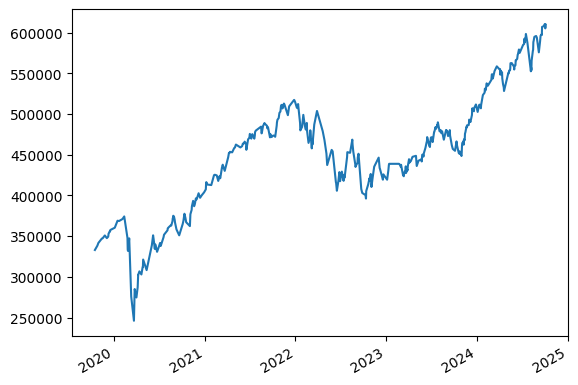

In [30]:
history_df["total_net_value"].plot()